<a href="https://colab.research.google.com/github/tylergusmyers/ML_token_prices/blob/master_som/notebook/btc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Required libraries** 

In [11]:
# Install the required libraries
from IPython.display import clear_output
try:
  #!pip install pystan
  !pip install pytrends
  !pip install yfinance
  !pip install yahoofinancials
except:
  print("Error installing libraries")
finally:
  clear_output()
  print('Libraries successfully installed')

Libraries successfully installed


In [12]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
#from sklearn.preprocessing import StandardScaler,OneHotEncoder
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt


#import yfinance as yf
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pytrends.request import TrendReq


**Build Bitcoin Historicall Data into Pandas DataFrame**

In [13]:
# Upload BitCoin historical data from Yahoo finance and load into Pandas DataFrame 
btc = yf.Ticker("BTC-USD")

# get historical market data
btc_usd_df = btc.history(
                          start='2017-01-01', 
                      end='2022-01-12', 
                      progress=False,
)


btc_usd_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0,0
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0,0
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0,0
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0,0
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0,0
...,...,...,...,...,...,...,...
2022-01-08,41561.464844,42228.941406,40672.277344,41733.941406,28066355845,0,0
2022-01-09,41734.726562,42663.949219,41338.160156,41911.601562,21294384372,0,0
2022-01-10,41910.230469,42199.484375,39796.570312,41821.261719,32104232331,0,0


In [14]:
# Drop columns "Dividens" and "Stocks Splits" as they are not relevant to crypto coins
btc_usd_df = btc_usd_df.drop(["Dividends", "Stock Splits"], axis=1)

btc_usd_df

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2022-01-08,41561.464844,42228.941406,40672.277344,41733.941406,28066355845
2022-01-09,41734.726562,42663.949219,41338.160156,41911.601562,21294384372
2022-01-10,41910.230469,42199.484375,39796.570312,41821.261719,32104232331


**Build Bitcoin Google Trend data into a DataFrame**

In [82]:
#Pull BitCoin global search trend Data from Google and load into a DataFrame

#pytrends = TrendReq(hl=’en-US’, tz=360)
pytrends = TrendReq()

#pytrends.build_payload(kw_list=['bitcoin', 'crypto', 'cryptocurrency', 'btc', 'BlockChain'], timeframe='2017-01-01 2022-01-12')

pytrends.build_payload(kw_list=['bitcoin'], timeframe='2017-01-01 2022-01-12')

# Interest

df = pytrends.interest_over_time().rename_axis('Date')


#df['isPartial'] = np.where((df.isPartial == 'False'), 0, df.isPartial)
#df['isPartial'] = np.where((df.isPartial == 'True'), 1, df.isPartial)

df = df.drop(["isPartial"], axis=1) #* 1000
df

,bitcoin
Date,
2017-01-01,7
2017-01-08,6
2017-01-15,5
2017-01-22,4
2017-01-29,4
...,...
2021-12-12,26
2021-12-19,24
2021-12-26,23


**Build a Pandas DataFrame of US Federal Holidays for the same time period**

In [83]:
dates_df = pd.DataFrame(
    {'Date':pd.date_range('2017-01-01', '2022-01-12')}
)


dates_df['holiday'] = dates_df['Date']

dates_df = dates_df.set_index('Date')
dates_df

,holiday
Date,
2017-01-01,2017-01-01
2017-01-02,2017-01-02
2017-01-03,2017-01-03
2017-01-04,2017-01-04
2017-01-05,2017-01-05
...,...
2022-01-08,2022-01-08
2022-01-09,2022-01-09
2022-01-10,2022-01-10


In [84]:
cal = calendar()

holidays = cal.holidays(
    start=dates_df['holiday'].min(),
    end=dates_df['holiday'].max()
)

holidays

DatetimeIndex(['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03',
               '2018-10-08', '2018-11-12', '2018-11-22', '2018-12-25',
               '2019-01-01', '2019-01-21', '2019-02-18', '2019-05-27',
               '2019-07-04', '2019-09-02', '2019-10-14', '2019-11-11',
               '2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20',
               '2020-02-17', '2020-05-25', '2020-07-03', '2020-09-07',
               '2020-10-12', '2020-11-11', '2020-11-26', '2020-12-25',
               '2021-01-01', '2021-01-18', '2021-02-15', '2021-05-31',
               '2021-07-05', '2021-09-06', '2021-10-11', '2021-11-11',
               '2021-11-25', '2021-12-24', '2021-12-31'],
              dtype='datetime64[ns]', freq=None)

In [85]:
dates_df['holiday'] = dates_df['holiday'].isin(holidays).astype(int) 
dates_df = dates_df #* 1000

dates_df

,holiday
Date,
2017-01-01,0
2017-01-02,1
2017-01-03,0
2017-01-04,0
2017-01-05,0
...,...
2022-01-08,0
2022-01-09,0
2022-01-10,0


In [124]:
#btc_usd_df_01 = pd.concat ([btc_usd_df , dates_df, df], axis=1).fillna(0)
#btc_usd_df_01 = pd.concat ([btc_usd_df, df ], axis=1) #.fillna(0)
btc_usd_df_01 = pd.concat ([btc_usd_df ], axis=1)

target_col = 'Close'


btc_usd_df_01 = btc_usd_df_01.dropna()
btc_usd_df_01

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2022-01-08,41561.464844,42228.941406,40672.277344,41733.941406,28066355845
2022-01-09,41734.726562,42663.949219,41338.160156,41911.601562,21294384372
2022-01-10,41910.230469,42199.484375,39796.570312,41821.261719,32104232331


**Split features and target sets into Trainng and test datasets**

In [125]:
# Function to split the preprocessed data into a training  80% and testing  20% dataset

def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(btc_usd_df, test_size=0.2)



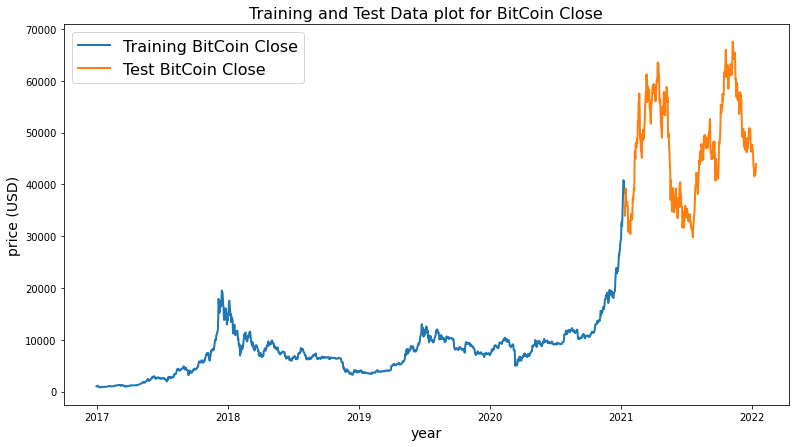

In [126]:
# Function to plot the test dataset and trainig dataset into a line

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price (USD)', fontsize=14)
    ax.set_xlabel('year', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

# Display the line chart of the line plot for both the trainig and the test data set    
    
line_plot(train[target_col], test[target_col], 'Training BitCoin Close', 'Test BitCoin Close', title='Training and Test Data plot for BitCoin Close')

In [127]:
# Function to Normalize the dataFrame data

def normalise_df(df):
  return df / df.iloc[0] - 1

def normalise_df_min_max(df):
  return (df - df.min()) / (data.max() - df.min())

In [128]:
def extract_period_data(df, period_len, zero_base=True):
  period_data = []
  for x in range(len(df) - period_len):
    tmp = df[x: (x + period_len)].copy()                

    if zero_base:
      tmp = normalise_df(tmp)
    period_data.append(tmp.values)
  return np.array(period_data)

In [129]:
def prepare_data(df, target_col, period_len, zero_base, test_size):
  train_data, test_data = train_test_split(df, test_size=test_size)
  X_train = extract_period_data(train_data, period_len, zero_base)
  X_test = extract_period_data(test_data, period_len, zero_base)
  y_train = train_data[target_col][period_len:].values
  y_test = test_data[target_col][period_len:].values
  if zero_base:
    y_train = y_train / train_data[target_col][:-period_len].values - 1
    y_test = y_test / test_data[target_col][:-period_len].values - 1
  
  return train_data, test_data, X_train, X_test, y_train, y_test

In [130]:
def build_lstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [131]:
# Input parameters

period_len = 30
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = 'linear'
output_size = 1


In [132]:
# Call the function prepare_data to compute the training and testing dataset

train, test, X_train, X_test, y_train, y_test = prepare_data(btc_usd_df_01, target_col, period_len=period_len, zero_base=zero_base, test_size=test_size)

#X_train

In [133]:
#Call the function build_lstm_model  to initialize and build the neural net model using the input parameter define above

model = build_lstm_model(X_train, output_size, lstm_neurons, activ_func=activ_func, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
46/46 [==============================] - 3s 26ms/step - loss: 0.0253
Epoch 2/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0094
Epoch 3/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0082
Epoch 4/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0068
Epoch 5/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0067
Epoch 6/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0058
Epoch 7/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0057
Epoch 8/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0057
Epoch 9/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0060
Epoch 10/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0048
Epoch 11/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0050
Epoch 12/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0048
Epoch 13/50
46/46 [==================

In [121]:
# Define the target and period to for use in the prediction
targets = test[target_col][period_len:]
preds = model.predict(X_test).squeeze()
preds

array([ 0.015949  ,  0.2621473 ,  0.3277214 ,  0.15119942, -0.06788807,
       -0.23182853,  0.0337365 , -0.10997514, -0.27769506, -0.19207239,
       -0.08397991, -0.07021396, -0.07296442, -0.005152  ,  0.28582543,
        0.06768943, -0.00287982,  0.24482803,  0.65223336,  0.526595  ,
        0.39109504,  0.37158486], dtype=float32)

In [122]:
# Review the mean_absoluter_error for the prediction with the test data

#targets = test[target_col][period_len:]

mean_absolute_error(preds, y_test)

0.15321518809533227

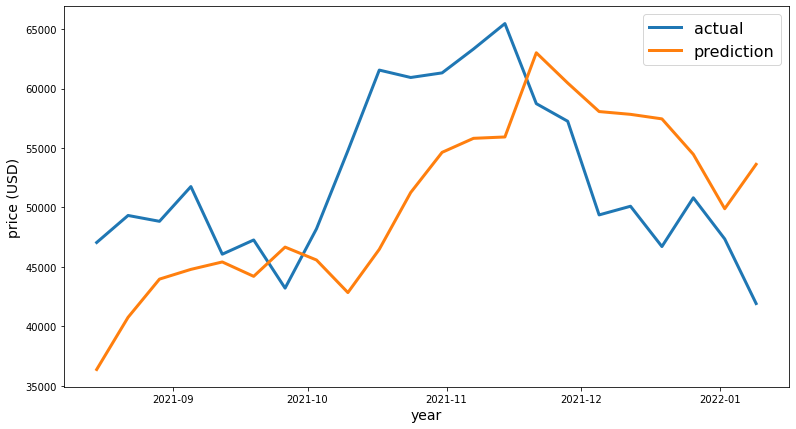

In [123]:
# Compare and visualize the prediction and the actual data
preds = test[target_col].values[:-period_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)